In [2]:
!pip install jovian --upgrade --quiet

In [3]:
content_path = 'images/trump.jpeg'
name_me = '0'

In [4]:
style_path = 'images/lines.jpg'

In [5]:
import tensorflow as tf


In [6]:
import functools
import time

import IPython.display as display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [7]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [8]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [9]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

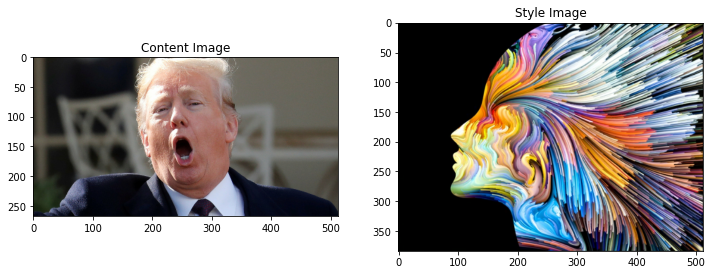

In [12]:
content_image = load_img(content_path)
style_image = load_img(style_path)
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [13]:
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 4s 0us/step


TensorShape([1, 1000])

In [14]:
 predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(
     prediction_probabilities.numpy())[0]
 [(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('suit', 0.25286293),
 ('Windsor_tie', 0.12051824),
 ('bow_tie', 0.060187038),
 ('ice_lolly', 0.04632095),
 ('cleaver', 0.030488934)]

In [17]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
     print(layer.name)

80142336/80134624 [==============================] - 0s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [18]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2']

# Style layer of interest
style_layers = [
    'block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [19]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [21]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

 #Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
     print(name)
     print("  shape: ", output.numpy().shape)
     print("  min: ", output.numpy().min())
     print("  max: ", output.numpy().max())
     print("  mean: ", output.numpy().mean())
     print()

block1_conv1
  shape:  (1, 384, 512, 64)
  min:  0.0
  max:  851.24554
  mean:  28.623495

block2_conv1
  shape:  (1, 192, 256, 128)
  min:  0.0
  max:  4819.444
  mean:  176.81908

block3_conv1
  shape:  (1, 96, 128, 256)
  min:  0.0
  max:  11835.67
  mean:  203.46228

block4_conv1
  shape:  (1, 48, 64, 512)
  min:  0.0
  max:  20370.773
  mean:  657.72955

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  3216.7651
  mean:  56.453167



In [22]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

In [23]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(
            inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [
            gram_matrix(style_output) for style_output in style_outputs
        ]

        content_dict = {
            content_name: value
            for content_name, value in zip(self.content_layers,
                                           content_outputs)
        }

        style_dict = {
            style_name: value
            for style_name, value in zip(self.style_layers, style_outputs)
        }

        return {'content': content_dict, 'style': style_dict}

In [24]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
     print("  ", name)
     print("    shape: ", output.numpy().shape)
     print("    min: ", output.numpy().min())
     print("    max: ", output.numpy().max())
     print("    mean: ", output.numpy().mean())
     print()

print("Contents:")
for name, output in sorted(results['content'].items()):
     print("  ", name)
     print("    shape: ", output.numpy().shape)
     print("    min: ", output.numpy().min())
     print("    max: ", output.numpy().max())
     print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005164385
    max:  19865.736
    mean:  304.42346

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  41351.562
    mean:  8739.737

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  280923.1
    mean:  9707.0205

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2298025.8
    mean:  170429.83

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  144789.67
    mean:  1659.754

Contents:
   block5_conv2
    shape:  (1, 16, 32, 512)
    min:  0.0
    max:  1523.9393
    mean:  15.307096


In [25]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [26]:
image = tf.Variable(content_image)

In [28]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [29]:
style_weight = 1e-2
content_weight = 1e4

In [30]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [31]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [32]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

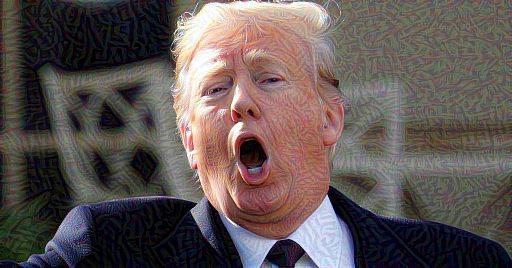

In [33]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

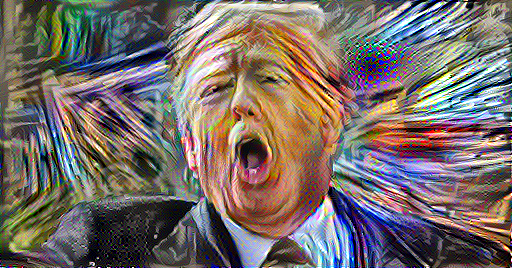

Train step: 100
.Buffered data was truncated after reaching the output size limit.

In [ ]:
import time

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print("Train step: {}".format(step))
tensor_to_image(image).save(f'outputs/{name_me}.jpg')
end = time.time()
print("Total time: {:.1f}".format(end - start))

In [ ]:
import os

import cv2
import numpy as np

img_array = []
for filename in os.listdir('outputs/'):
    print(f'outputs/{filename}')
    try:
        img = cv2.imread(f'outputs/{filename}')
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)
    except Exception as e:
#         print(e)
        pass

out = cv2.VideoWriter('nnBrook.avi', cv2.VideoWriter_fourcc(*'DIVX'), 4, (512, 288))

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()